# Setup

In [1]:
#@title Install Packages
!pip install diffusers==0.27 accelerate==0.28
!git clone https://github.com/vita-epfl/CODE.git

In [2]:
#@title Create the model { run: "auto" }
from diffusers import DDPMPipeline, DDIMPipeline
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_id = "google/ddpm-ema-church-256" #@param ["google/ddpm-ema-celebahq-256", "google/ddpm-ema-church-256", "google/ddpm-ema-bedroom-256"]

ddpm = DDPMPipeline.from_pretrained(model_id)
ddim = DDIMPipeline.from_pretrained(model_id)
unet = ddim.unet
# unet = unet.to(device)
scheduler = ddim.scheduler
scheduler.set_timesteps(200)
ddpm.scheduler.set_timesteps(200)

number_of_sample = 1
shape = [number_of_sample, 3, 256, 256]
# random_seed = torch.randn(shape).to(device)
num_timesteps = int(ddpm.scheduler.betas.shape[0])
betas = ddpm.scheduler.betas
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)

from tqdm import tqdm

def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    try:
        res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    except:
        res = arr.to(device=timesteps.device)[timesteps].float()

    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


dynamic_threshol_ratio = 0.98
dynamic_threshold_max = 1.3

@torch.no_grad()
def langevin_sampling(inputs, t, t_prev, steps = 100, epsilon = 1e-5,min_variance = -1,
                     denoising_step = True, clip_prev = False, clip_now = False, dynamic_thresholding = False,  power  = 0.5):

    model = ddpm.unet.to(device)
    alphas_cumprod = ddpm.scheduler.alphas_cumprod.cpu().numpy()
    model = ddpm.unet.to(device)
    index = t
    timesteps = ddpm.scheduler.timesteps.tolist()[::-1]
    t = timesteps[index]
    # print('index', index)
    # print('t', t)

    t = torch.tensor([t] * inputs.shape[0]).to(device)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    std = torch.sqrt(variance)
    std_epsilon = []
    mean_epsilon = []
    if t_prev is not None:
        t_prev = torch.tensor([t_prev] * inputs.shape[0]).to(device)
        mean_coef_t_prev = torch.sqrt(_extract_into_tensor(alphas_cumprod, t_prev , inputs.shape))
        variance_t_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_t_prev)
        if clip_inputs_langevin and (index > stop_clipping_at):
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds)
        noise_estimate_t_prev = model(inputs, t_prev)['sample']
        x0_t_1 = (inputs - std_prev * noise_estimate_t_prev)/mean_coef_t_prev
        if dynamic_thresholding:
            x0_t_1 = _threshold_sample(x0_t_1, dynamic_threshol_ratio, dynamic_threshold_max)
        if clip_prev:
            x0_t_1 = x0_t_1.clamp(-1,1)
        inputs = inputs + x0_t_1 * (mean_coef_t - mean_coef_t_prev)

    if min_variance > 0:
        alpha_coef =  (variance/min_variance) * epsilon
    else:
        alpha_coef = torch.ones_like(variance) * epsilon
    with torch.no_grad():
        for i in range(steps):
            if clip_inputs_langevin and (index > stop_clipping_at):
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds)
            noise_estimate = model(inputs, t)['sample']
            if dynamic_thresholding:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = _threshold_sample(x0_t, dynamic_threshol_ratio, dynamic_threshold_max)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            elif clip_now:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = x0_t.clamp(-1,1)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            std_epsilon.append(noise_estimate[0].cpu().std().item())
            mean_epsilon.append(noise_estimate[0].cpu().mean().item())
            score = - noise_estimate / std
            noise = torch.randn(inputs.shape).to(device)
            if steps > 1:
                inputs = (inputs + alpha_coef * score) + torch.pow(2*alpha_coef, power) * noise
        if denoising_step:
            if clip_inputs_langevin and (index > stop_clipping_at):
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds)
            noise_estimate = model(inputs, t)['sample']
            score = - noise_estimate / std
            inputs = (inputs + alpha_coef * score)
    return inputs, alpha_coef, std_epsilon, mean_epsilon

def _threshold_sample(sample: torch.FloatTensor, dynamic_thresholding_ratio: float, sample_max_value : float = 5/3) -> torch.FloatTensor:
    """
    "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
    prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
    s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
    pixels from saturation at each step. We find that dynamic thresholding results in significantly better
    photorealism as well as better image-text alignment, especially when using very large guidance weights."

    https://arxiv.org/abs/2205.11487
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape

    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

    # Flatten sample for doing quantile calculation along each image
    sample = sample.reshape(batch_size, channels * np.prod(remaining_dims))

    abs_sample = sample.abs()  # "a certain percentile absolute pixel value"
    s = torch.quantile(abs_sample, dynamic_thresholding_ratio, dim=1)
    s = torch.clamp(
        s, min=1, max=sample_max_value
    )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]
    s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
    sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

    sample = sample.reshape(batch_size, channels, *remaining_dims)
    sample = sample.to(dtype)

    return sample

@torch.no_grad()
def _clip_inputs(sample: torch.FloatTensor, t : int, number_of_stds: float = 2., original_img = None, previous_x = None):
    """
    Cliping the inputs with an confidence interval given by the diffusion schedule
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape
    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half
    alphas_cumprod = ddpm.scheduler.alphas_cumprod
    alphas = ddpm.scheduler.alphas
    alpha_t = ddpm.scheduler.alphas_cumprod[t]
    sqrt_alpha_local_t = torch.sqrt(alphas[t])
    one_minus_alphas_local_t = torch.sqrt(1-alphas[t]).item()
    sqrt_alpha_t = torch.sqrt(alpha_t).item()
    one_minus_sqrt_alpha_t = torch.sqrt(1-alpha_t).item()
    if original_img is not None and previous_x is not None and t > 0:
        mean = original_img * torch.sqrt(alphas_cumprod[t-1]).item() * (betas[t]).item() / (1 - alphas[t].item())
        mean += previous_x * torch.sqrt(alphas[t]).item() * (1 - alphas_cumprod[t-1].item()) / (1-alphas_cumprod[t].item())
        plt.imshow(mean[0].permute(1,2,0).cpu()/2+0.5)
        plt.show()
        std = betas[t].item() * (1-alphas_cumprod[t-1].item())/(1-alphas_cumprod[t].item())
        confidence_interval = [mean - number_of_stds * std, mean + number_of_stds * std]
    elif original_img is None:
        confidence_interval = [-sqrt_alpha_t - number_of_stds * one_minus_sqrt_alpha_t, sqrt_alpha_t + number_of_stds * one_minus_sqrt_alpha_t]
    else:
        confidence_interval = [sqrt_alpha_t * original_img - number_of_stds * one_minus_sqrt_alpha_t,
                            sqrt_alpha_t * original_img + number_of_stds * one_minus_sqrt_alpha_t]
    sample = torch.clamp(sample, confidence_interval[0], confidence_interval[1])
    sample = sample.to(dtype)
    return sample

@torch.no_grad()
def ddim_step(inputs, t, clip_denoised = False, dynamic_thresholding = True, clip_value = 1, sigma = 0,
            clip_inputs = False, number_of_stds = 2, stop_clipping_at = 0, prev_pred = None, previous_x = None,
            forward = True, number_of_sample = 1):
    alphas_cumprod = ddpm.scheduler.alphas_cumprod.cpu().numpy()
    number_of_timesteps = ddpm.scheduler.betas.shape[0]
    index = t
    timesteps = ddpm.scheduler.timesteps.tolist()[::-1]
    t = timesteps[index]

    model = ddpm.unet.to(device)

    if index > 0 and forward:
        t_prev = timesteps[index-1]
        t_prev = torch.tensor([t_prev] * inputs.shape[0]).to(device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    elif index < number_of_timesteps :
        t_prev = timesteps[index+1]
        t_prev = torch.tensor([t_prev] * inputs.shape[0]).to(device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    t = torch.tensor([t] * inputs.shape[0]).to(device)
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    std = torch.sqrt(variance)
    if clip_inputs:
        if index > stop_clipping_at:
            if forward:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred, previous_x = previous_x)
            else:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred, previous_x = None)

    noise_estimate = model(inputs, t)['sample']
    std_epsilon = noise_estimate[0].cpu().std().item()
    mean_epsilon = noise_estimate[0].cpu().mean().item()
    x0_t = (inputs - std * noise_estimate)/mean_coef_t
    if dynamic_thresholding:
        x0_t = _threshold_sample(x0_t, dynamic_threshol_ratio, dynamic_threshold_max)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    elif clip_denoised:
        x0_t = x0_t.clamp(-1,1)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    if sigma > 0:
        sigma_t = sigma * torch.sqrt((variance_prev)/(variance)) * torch.sqrt(1 - (1-variance)/ (1-variance_prev))
    else:
        sigma_t = 0.
    noise= torch.randn_like(inputs)
    x_prev = torch.sqrt(1-variance_prev) / torch.sqrt(1-variance) * ((inputs - std * noise_estimate)) + torch.sqrt(variance_prev - sigma_t**2)  * noise_estimate + sigma_t * noise
    return x_prev, std_epsilon, mean_epsilon, x0_t

@torch.no_grad()
def editing_with_ode(latent_codes, t_start = 1000, annealing = False,
                    annealing_cst = 0.8, epsilon = 1e-8,
                    steps = 20, power =0.5, min_latent_space_update = 99,
                    min_variance = -1. , number_of_sample = 1,
                    corrector_step = 1, use_std_schedule = False, start_from_latent = False):

    alphas_cumprod = ddpm.scheduler.alphas_cumprod
    timesteps = ddpm.scheduler.timesteps.tolist()
    stds = torch.sqrt(1-alphas_cumprod)
    epsilon_base = epsilon
    list_of_evolution_reverse = []
    final_samples = []
    t_valid = list(range(0, min(len(latent_codes)+1,len(timesteps))))
    model = ddpm.unet
    # print("start", t_start)
    t_start = min(t_start, min(len(latent_codes)+1,len(timesteps)))
    # print("new_start", t_start)
    if t_start > min_latent_space_update + corrector_step and corrector_step > 1:
        correction_latents = np.linspace(min_latent_space_update, t_start-1, corrector_step).astype(int).tolist()
        epsilon_correction = np.geomspace(1,100,len(timesteps))[::-1]
        if use_std_schedule:
            epsilon_correction = 1 / stds.cpu().numpy()
        epsilon_correction = epsilon_correction / epsilon_correction[len(timesteps)-1]
    else:
        epsilon_correction = np.geomspace(1,100,len(timesteps))[::-1]
        epsilon_correction = epsilon_correction / epsilon_correction[len(timesteps)-1]
        correction_latents = [t_start-1]
    if start_from_latent:
        t_valid = t_valid[::-1]
    else:
        t_valid = range(t_start)[::-1]

    with torch.no_grad():
        inputs = latent_codes[t_valid[0]]
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(0)
            batch_size = 1
        elif len(inputs.shape) == 4:
            batch_size = inputs.shape[0]
        else:
            raise NotImplementedError
        # Make sure samples are next to one another in the grid
        if batch_size > 1 and number_of_sample > 1:
            inputs = inputs.split(1, dim=0)
            inputs = [inp.repeat(number_of_sample, 1, 1, 1) for inp in inputs]
            inputs = torch.cat(inputs)
        elif number_of_sample > 1:
            inputs = inputs.repeat(number_of_sample, 1, 1, 1)
        else:
            inputs = inputs
        inputs = inputs.to(device)
        for t in tqdm(t_valid):
            # print(t)
            # print("correction_latents", correction_latents)
            if t in correction_latents:
                epsilon = epsilon_base * epsilon_correction[t]
                # LOG.info(f'At time {t}, epsilon is {epsilon}')
                if annealing>1:
                    new_epsilon = epsilon
                    step_per_epsilon = steps // len(range(int(annealing)))
                    for j in range(int(annealing)):
                        # LOG.info(f"Orignal Epsilon : {epsilon}, Update_{j}_epsilon : {new_epsilon}")
                        inputs, alpha_coef, _, _ = langevin_sampling(inputs, t, None, steps = step_per_epsilon, epsilon = new_epsilon,
                                            min_variance = min_variance, clip_prev = False, clip_now = False,
                                            dynamic_thresholding=dynamic_thresholding_langevin, power = power)
                        new_epsilon  = new_epsilon * annealing_cst

                else:
                    inputs,alpha_coef, _, _ = langevin_sampling(inputs, t, None, steps = steps, epsilon = epsilon,
                            min_variance = min_variance, clip_prev = False, clip_now = False,
                            dynamic_thresholding=dynamic_thresholding_langevin, power = power)

                for h in range(len(inputs)):
                        list_of_evolution_reverse.append(inputs[h].cpu())

            inputs, _, _, _ = ddim_step(inputs, t, clip_denoised = False, dynamic_thresholding = dynamic_thresholding_ddim,
                                                        clip_value = 1, sigma = 0,
                                                        clip_inputs = clip_input_decoding, stop_clipping_at = stop_clipping_at,
                                                        prev_pred = None, previous_x = None,
                                                        forward = True, number_of_sample = number_of_sample)

            for h in range(len(inputs)):
                list_of_evolution_reverse.append(inputs[h].cpu())
        for sample in list_of_evolution_reverse[-batch_size*number_of_sample:]:
            final_samples.append(sample)

        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
    return list_of_evolution_reverse, final_samples

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

# Guided Generation

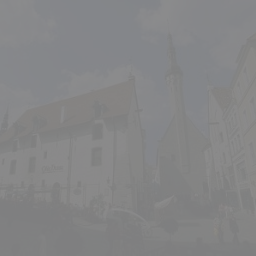

In [3]:
#@title Choose Image { run: "auto" }
import ipywidgets as widgets
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

# model_id = "google/ddpm-ema-celebahq-256"
# Specify your folder path here
folder_path = f'/content/CODE/docs/demo_imgs/{model_id}'

img_name = "contrast.png"#@param ["fog.png", "contrast.png"]

from PIL import Image

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor()
])

img = Image.open(f"/content/CODE/docs/images/demo_imgs/{model_id}/{img_name}").convert('RGB')
img_tensor = transform(img) * 2 - 1
img

In [4]:
#@title Choose Generation Parametes { run: "auto" }

#@markdown **How many samples to create**
batch_size =  1#@param {type:"number"}

#@markdown **How many Langevin Steps to do**
#@markdown > The more steps you do, the better is the algorithm convergence. \
#@markdown > We suggest to set it to a value of 250 for a balance between speed and quality.
langevin_steps =  250#@param {type:"number"}

#@markdown **Which latent space to update in**
#@markdown > The latent space choice depends on the type of changes you want to apply on the input image. \
#@markdown > For corruption types as *gaussian_blur* and *speckle_noise* we are interested in adding fine-grained details so it's best to use a shallow latent space for the updates (e.g. 20 or 40). \
#@markdown > For corruptions such as *fog* and *contrast* the changes are harder to recover because they include large whole-image color variations and masking, thus it's advised to use deeper latents (e.g. 200).
latent = 200#@param {type:"number"}

#@markdown **The epsilon step size to take at each langevin step**
#@markdown > Changes in deeper latent spaces are more delicate to deal with, so using small values for epsilon is advised to avoid diverging too much from the input (e.g. in a range 1e-4 to 1e-6). \
#@markdown > For shallower latent spaces a larger value (e.g. in a range 1e-2 to 1e-4) is advised. \
epsilon = 1.15e-5# @param {type:"number"}

#@markdown **Activate Confidence-Based Clipping**
#@markdown > Useful to allow the model to disregard some pixels. Works better for certain types of corruption.
use_cbc = False# @param {type:"boolean"}
clip_input = use_cbc

#@markdown **Confidence parameter η**
#@markdown > Regulates the confidence allowed for the clipping in terms of std. η = 2 means that values within 2 standard deviations are allowed.
number_of_stds = 1.7#@param {type:"number"}

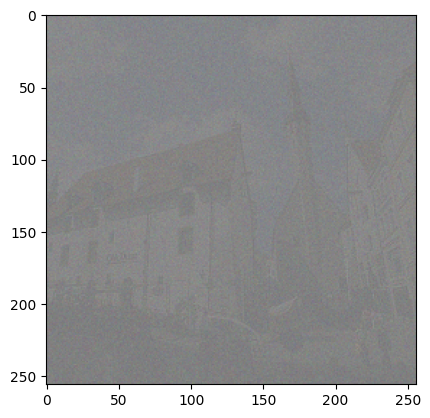

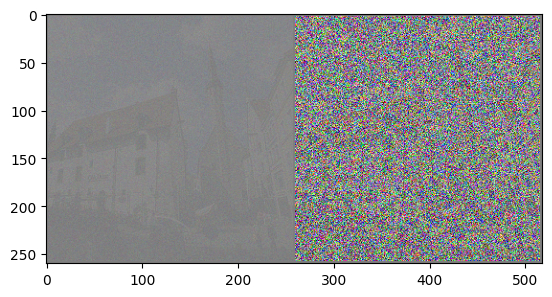

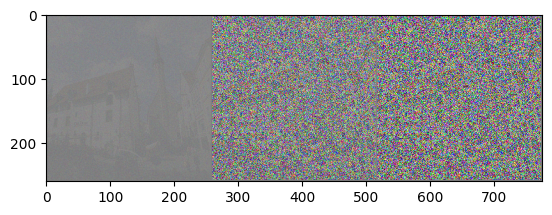

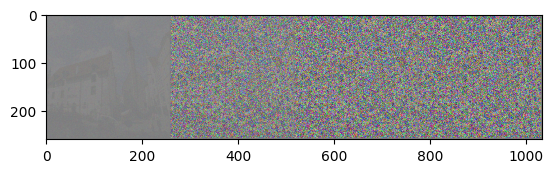

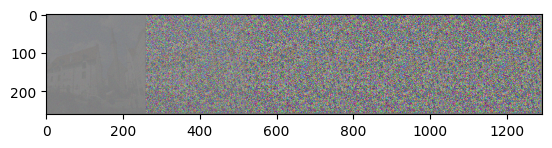

In [5]:
#@title Run DDIM Inversion
#@markdown This cell runs the DDIM inversion which to bring back the image into the desired latent space, which is a prerequisite for CODE.
#@markdown > **_NOTE_**: No need to run this cell again if you didn't change the model or the image


inputs = img_tensor.unsqueeze(0).to(device) + 0.01 * torch.randn_like(img_tensor).to(device)

noisified = True

dynamic_thresholding_ddim = True
dynamic_thresholding_langevin = True
stop_clipping_at = 0
clip_input_decoding = False
clip_input_encoding = False
clip_inputs_langevin = False

list_of_evolution = []
latent_codes = []
list_std_encoding = []
list_mean_encoding = []
if noisified:
    inputs = inputs + 0.01 * torch.randn_like(inputs)
with torch.no_grad():
    latent_codes.append(inputs.cpu())
    for t in range(0,ddpm.scheduler.timesteps.shape[0]-1):
        inputs, std_eps, mean_eps, x0_t = ddim_step(inputs, t, sigma = 0.,
                                clip_denoised=False,dynamic_thresholding=dynamic_thresholding_ddim,  forward=False,
                                clip_inputs = clip_input,
                                number_of_stds = number_of_stds ,prev_pred = None)
        latent_codes.append(inputs.cpu())
        list_std_encoding.append(std_eps)
        list_mean_encoding.append(mean_eps)

        if t % 40 == 0 or t == ddpm.scheduler.timesteps.shape[0]-1:
            for i in inputs:
                list_of_evolution.append(i.cpu())
            plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
            plt.show()

100%|██████████| 199/199 [01:32<00:00,  2.16it/s]


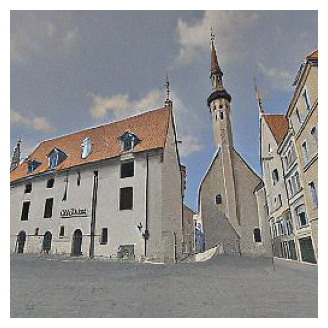

In [6]:
#@title Run CODE
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(12)

annealing = 4
annealing_cst = 0.8
min_latent_space_update = 20
number_of_latents_corrected = 2
use_std_schedule = False
start_from_latent = True if use_cbc else False


list_of_evolution_reverse, samples = editing_with_ode(latent_codes, t_start = latent-1, annealing = annealing,
                                        annealing_cst = annealing_cst, epsilon = epsilon,
                                        steps = langevin_steps, power =0.5, min_latent_space_update = min_latent_space_update,
                                        min_variance = -1. , number_of_sample = number_of_sample,
                                        corrector_step = number_of_latents_corrected, use_std_schedule = use_std_schedule,
                                        start_from_latent = start_from_latent)
plt.figure(figsize=[4*batch_size,4])
plt.imshow(make_grid(torch.stack(list_of_evolution_reverse[-batch_size:]).cpu()).permute(1,2,0).cpu()/2+0.5)
plt.axis("off")
plt.show()